In [1]:
import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
from os import path, getcwd, environ
import pandas as pd
import numpy as np
from utils import data

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
cohort = data.init_cohort()
df_annotations = cohort.load_polyphen_annotations(as_dataframe=True)
df_annotations = df_annotations[df_annotations.annotation_found]
df_annotations["chr_short"] = df_annotations.chrom.apply(lambda s: s.split("chr")[1])

{'dataframe_hash': -2899676230513618006,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [3]:
df_ddr_genes = pd.read_excel(
    path.join(data.REPO_DATA_DIR, "ddr_gene_list.xlsx"))

In [4]:
ddr_cols = list(df_ddr_genes.columns)
ddr_cols.remove("CellSig")
ddr_cols.remove("Lit")
ddr_cols = ddr_cols[1:11]

In [5]:
def keep_gene(row):
    gene = row["Gene"]
    for ddr_col in ddr_cols:
        if str(row[ddr_col]).strip() == "1":
            return True
    return False

In [6]:
df_ddr_genes["keep_gene"] = df_ddr_genes.apply(keep_gene, axis=1)

In [7]:
ddr_gene_names = set(df_ddr_genes[df_ddr_genes.keep_gene].Gene)

In [8]:
len(df_ddr_genes)

406

In [9]:
len(ddr_gene_names)

352

In [10]:
aliases = pd.read_csv(path.join(data.REPO_DATA_DIR, "Homo_sapiens.gene_info"), delimiter="\t")

In [11]:
synmap = {}
for i, row in aliases.iterrows():
    symbol = row["Symbol"]
    syns = set(row["Synonyms"].split("|"))
    if "-" in syns:
        syns.remove("-")
    syns.add(symbol)
    new_syns = set()
    for syn in syns:
        new_syns.add(syn.upper())
        new_syns.add(syn)
    syns = new_syns
    for syn in syns:
        synmap[syn] = syns

In [12]:
id_map = {"MGC90512": "ENSG00000242537",
          "MRE11B": "ENSG00000242537",
          "FLJ35220": "ENSG00000173818",
          "SE20-4": "ENSG00000184205"}

In [13]:
from pyensembl import cached_release
ensembl = cached_release("75")
ddr_genes = set()
for gene_name in ddr_gene_names:
    def get_gene(gene_name):
        all_possible_genes = set()
        if gene_name.upper() in id_map.keys():
            all_possible_genes = set([ensembl.gene_by_id(id_map[gene_name.upper()])])
        else:
            if gene_name.upper() not in synmap:
                return None
            syns = synmap[gene_name.upper()]
            for syn in syns:
                try:
                    possible_genes = ensembl.genes_by_name(syn)
                except:
                    continue
                for possible_gene in possible_genes:
                    all_possible_genes.add(possible_gene) 
        if len(all_possible_genes) == 0:
            return None
        return all_possible_genes
    genes = get_gene(gene_name)
    if genes is not None:
        for gene in genes:
            ddr_genes.add(gene)
    else:
        print("Alias not found for %s" % gene_name)

Alias not found for MYT2


In [14]:
ddr_annotations = []
for gene in ddr_genes:
    df_annotations_gene = df_annotations[
        (df_annotations.chr_short == gene.contig) & 
        (df_annotations.pos >= gene.start) &
        (df_annotations.pos <= gene.end)]
    if len(df_annotations_gene) > 0:
        ddr_annotations.append(df_annotations_gene)
df_ddr_annotations = pd.concat(ddr_annotations)

In [15]:
df_ddr_annotations

,chrom,pos,ref,alt,annotation_found,gene,protein,aa_change,hvar_pred,hvar_prob,hdiv_pred,hdiv_prob,patient_id,chr_short
1481,chr2,48023086,G,A,True,MSH6,P52701-2,E171K,benign,0.060,benign,0.065,2131,2
405,chr10,112341725,G,A,True,SMC3,Q9UQE7,E198K,possibly damaging,0.765,probably damaging,0.969,2131,10
557,chr3,37067192,C,T,True,MLH1,P40692,S368L,benign,0.011,benign,0.016,5122,3
2486,chr8,141521728,C,G,True,CHRAC1,Q9NRG0,L44V,benign,0.038,benign,0.103,0040,8
37,chr1,76345769,C,T,True,MSH4,O15457,S571L,possibly damaging,0.543,possibly damaging,0.775,1849,1
799,chr19,49510391,G,A,True,RUVBL2,B3KNL2,G94S,probably damaging,0.997,probably damaging,1.000,2849,19
1385,chr19,18966045,G,A,True,UPF1,Q92900-2,G513D,benign,0.071,benign,0.086,0040,19
574,chr19,18965421,G,A,True,UPF1,Q92900-2,E390K,possibly damaging,0.753,possibly damaging,0.942,6800,19
273,chr12,4655502,G,C,True,RAD51AP1,Q96B01-2,Q79H,probably damaging,0.939,probably damaging,0.999,2937,12
2720,chrX,135584986,G,C,True,HTATSF1,O43719,R207T,probably damaging,0.986,probably damaging,0.999,2131,X


In [16]:
def num_ddr(row, allowed):
    patient_id = row["patient_id"]
    df_ddr_patient = df_ddr_annotations[df_ddr_annotations.patient_id == patient_id]
    df_ddr_patient = df_ddr_patient[df_ddr_patient.hvar_pred.isin(allowed)]
    return len(df_ddr_patient)

In [17]:
def num_ddr_probably(row):
    return num_ddr(row, allowed=["probably damaging"])

In [18]:
def num_ddr_possibly(row):
    return num_ddr(row, allowed=["possibly damaging", "probably damaging"])

In [19]:
def has_ddr_probably(row):
    return num_ddr(row, allowed=["probably damaging"]) >= 1

In [20]:
def has_ddr_possibly(row):
    return num_ddr(row, allowed=["possibly damaging", "probably damaging"]) >= 1

In [21]:
from utils.paper import *

Mann-Whitney test: U=79.5, p-value=0.595648427729 (two-sided)
{{{num_ddr_probably_plot}}}
{{{num_ddr_probably_benefit:0.00 (range 0.00-1.00)}}}
{{{num_ddr_probably_no_benefit:0.00 (range 0.00-3.00)}}}
{{{num_ddr_probably_mw:n=25, Mann-Whitney p=0.60}}}


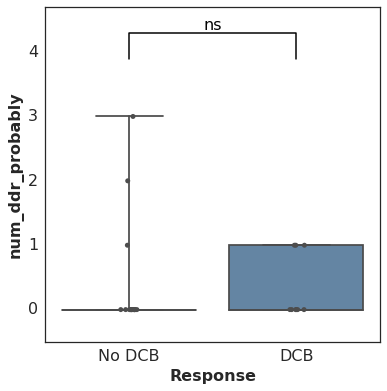

In [22]:
mann_whitney_hyper_label_printer(cohort.plot_benefit(num_ddr_probably), "num_ddr_probably")

has_ddr_probably  False  True 
Response                      
DCB                   6      3
No DCB               13      3
Fisher's Exact Test: OR: 0.461538461538, p-value=0.630039525692 (two-sided)
{{{has_ddr_probably_fishers:n=25, Fisher's Exact p=0.63}}}


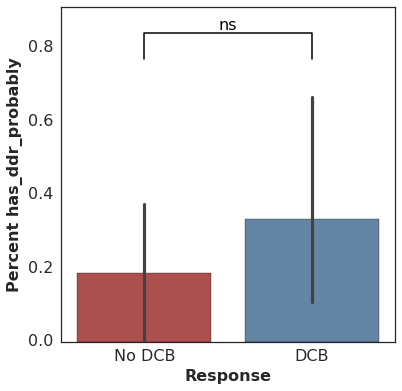

In [23]:
hyper_label_printer(fishers_exact_formatter, "has_ddr_probably_fishers", results=cohort.plot_benefit(has_ddr_probably))

Mann-Whitney test: U=92.0, p-value=0.196086956526 (two-sided)
{{{num_ddr_possibly_plot}}}
{{{num_ddr_possibly_benefit:1.00 (range 0.00-2.00)}}}
{{{num_ddr_possibly_no_benefit:0.00 (range 0.00-3.00)}}}
{{{num_ddr_possibly_mw:n=25, Mann-Whitney p=0.20}}}


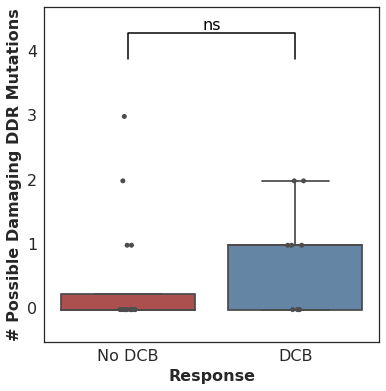

In [24]:
mann_whitney_hyper_label_printer(cohort.plot_benefit({"# Possible Damaging DDR Mutations": num_ddr_possibly}), "num_ddr_possibly")

With Damaging DDR Mutations  False  True 
Response                                 
DCB                              4      5
No DCB                          12      4
Fisher's Exact Test: OR: 0.266666666667, p-value=0.199755258875 (two-sided)
{{{has_ddr_possibly_fishers:n=25, Fisher's Exact p=0.20}}}


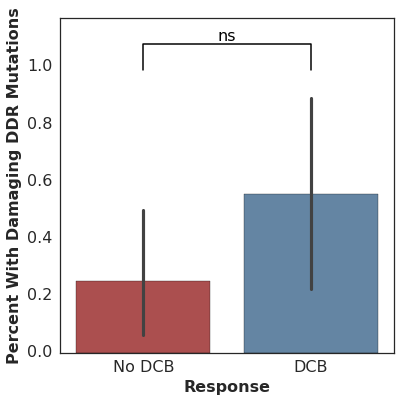

In [25]:
hyper_label_printer(fishers_exact_formatter, "has_ddr_possibly_fishers", results=cohort.plot_benefit({"With Damaging DDR Mutations": has_ddr_possibly}))

In [26]:
from cohorts.functions import missense_snv_count

In [27]:
def missense_ddr_snv_count(row, cohort, filter_fn=None, normalized_per_mb=None, **kwargs):
    from cohorts.variant_filters import no_filter
    from cohorts.utils import first_not_none_param
    filter_fn = first_not_none_param([filter_fn, cohort.filter_fn], no_filter)
    normalized_per_mb = first_not_none_param([normalized_per_mb, cohort.normalized_per_mb], False)
    
    patient_id = row["patient_id"]
    def ddr_filter_fn(filterable_effect):
        if filter_fn is not None:
            return (filter_fn(filterable_effect) and 
                    filterable_effect.effect.gene in ddr_genes)
        return filterable_effect.effect.gene.id in impact_gene_ids
    return missense_snv_count(row, cohort, filter_fn=ddr_filter_fn)

inner join with ensembl_coverage: 25 to 25 rows
Mann-Whitney test: U=97.0, p-value=0.160848837562 (two-sided)


MannWhitneyResults(U=97.0, p_value=0.160848837562, sided_str='two-sided')

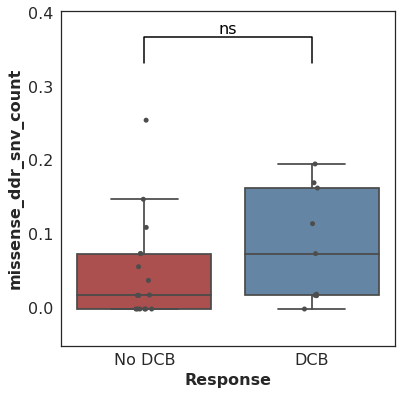

In [28]:
cohort.plot_benefit(missense_ddr_snv_count)

Mann-Whitney test: U=101.0, p-value=0.215999754743 (two-sided)


MannWhitneyResults(U=101.0, p_value=0.215999754743, sided_str='two-sided')

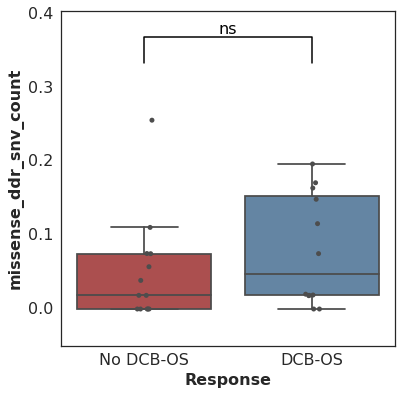

In [29]:
cohort.plot_benefit_os(on=missense_ddr_snv_count)

In [30]:
df_clinical = cohort.as_dataframe()

In [31]:
df_ddr_annotations.merge(df_clinical, on="patient_id").to_csv("ddr_polyphen.csv", encoding='utf-8')